# ConvKAN-Based Image Super-Resolution Training

This notebook implements a Convolutional Kolmogorov-Arnold Network (ConvKAN) architecture for image super-resolution. ConvKAN replaces traditional convolutional layers with learnable activation functions based on splines, potentially offering better feature learning capabilities.

## Project Overview
- **Task**: Image Super-Resolution - enhance bicubic-upsampled images
- **Architecture**: ConvKAN with residual blocks
- **Input**: Low-resolution images (64×64) upsampled to 256×256 via bicubic interpolation
- **Output**: High-resolution images at 256×256 with restored details
- **Loss Function**: L1 Loss (Mean Absolute Error)

## Key Differences from U-Net
- Uses ConvKAN layers instead of standard Conv2d
- Employs residual connections for deeper feature learning
- No downsampling - operates at constant 256×256 resolution
- Focuses on detail restoration rather than spatial transformation

---

## 1. Import Dependencies and Environment Setup

### GPU Configuration
- `CUDA_VISIBLE_DEVICES`: Select which GPU to use (default: GPU 1)
- `PYTORCH_CUDA_ALLOC_CONF`: Reduce memory fragmentation with expandable segments

### Key Libraries
- **convkan**: The ConvKAN layer implementation
- **torch**: PyTorch deep learning framework
- **PIL**: Image loading and preprocessing

In [11]:
import os
# Select GPU (change to '0' for GPU0, or remove line to use default)
os.environ.setdefault('CUDA_VISIBLE_DEVICES', '1')
# Reduce GPU memory fragmentation
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import glob
import numpy as np
from tqdm import tqdm
from pathlib import Path

# Import ConvKAN - install via: pip install convkan
try:
    from convkan import ConvKAN, LayerNorm2D
    print("✓ ConvKAN imported successfully")
except ImportError:
    print("ERROR: convkan is not installed. Run: pip install convkan")
    raise

✓ ConvKAN imported successfully


## 2. Device Configuration

Check CUDA availability and display GPU information.

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB')

Using device: cuda
GPU: Quadro RTX 6000
Memory: 22.15 GB


## 3. Dataset Class

### SRDataset: Super-Resolution Dataset

**Key Change: Using PixelShuffle Architecture (Memory-Efficient)**

**Data Flow:**
1. Load LR image from disk (64×64)
2. Load corresponding HR image (256×256)
3. **Resize LR to 128×128** ← Network processes at this size (saves memory!)
4. **Resize HR to 256×256** ← Keep original size
5. Model uses PixelShuffle internally: 128×128 → 256×256

**Why This is More Efficient:**
- ConvKAN processes at 128×128, using only 1/4 memory vs 256×256
- PixelShuffle upsampling is efficient (just rearranges pixels)
- This architecture is proven to work in the reference implementation

In [13]:
class SRDataset(Dataset):
    """Super-Resolution Dataset with efficient resizing for PixelShuffle"""
    def __init__(self, hr_dir, lr_dir, lr_size=128, hr_size=256, transform=None):
        self.hr_dir = Path(hr_dir)
        self.lr_dir = Path(lr_dir)
        self.lr_size = lr_size  # Network processes at this size
        self.hr_size = hr_size  # Target output size
        self.transform = transform
        
        # Load all image file paths
        self.hr_images = sorted(list(self.hr_dir.glob('*.png')))
        self.lr_images = sorted(list(self.lr_dir.glob('*.png')))
        
        # Verify dataset integrity
        if not self.hr_images or not self.lr_images:
            raise IOError(f"No images found in {hr_dir} or {lr_dir}")
        
        assert len(self.hr_images) == len(self.lr_images), \
            f"Mismatch: {len(self.hr_images)} HR vs {len(self.lr_images)} LR images"
        
        print(f"Dataset loaded: {len(self.hr_images)} image pairs")
        
        # Check actual image sizes
        sample_lr = Image.open(self.lr_images[0])
        sample_hr = Image.open(self.hr_images[0])
        print(f"Original LR size: {sample_lr.size}")
        print(f"Original HR size: {sample_hr.size}")
        print(f"LR will be resized to: {lr_size}×{lr_size} (network input)")
        print(f"HR will be resized to: {hr_size}×{hr_size} (target output)")
        
    def __len__(self):
        return len(self.hr_images)
    
    def __getitem__(self, idx):
        # Load images
        hr_img = Image.open(self.hr_images[idx]).convert('RGB')
        lr_img = Image.open(self.lr_images[idx]).convert('RGB')
        
        # Resize to appropriate sizes for PixelShuffle architecture
        lr_img = lr_img.resize((self.lr_size, self.lr_size), Image.BICUBIC)
        hr_img = hr_img.resize((self.hr_size, self.hr_size), Image.BICUBIC)
        
        # Apply transforms (to tensor)
        if self.transform:
            hr_img = self.transform(hr_img)
            lr_img = self.transform(lr_img)
        
        return lr_img, hr_img

## 4. ConvKAN Model Architecture

### What is ConvKAN?

ConvKAN (Convolutional Kolmogorov-Arnold Network) replaces traditional convolutional layers with learnable spline-based activation functions.

**Key Architecture: PixelShuffle Upsampling**

```
Input: RGB 128×128 (3 channels)
    ↓
[Head: ConvKAN 3→16 channels]  ← Initial feature extraction
    ↓
[Body: 2× ResBlock (16 ch)]    ← Feature processing at 128×128
    ↓
[Upsample: ConvKAN 16→64 + PixelShuffle(2×)]  ← 128×128 → 256×256
    ↓
[Tail: Conv2d 16→3]            ← RGB reconstruction
    ↓
Output: RGB 256×256 (3 channels)
```

**Why PixelShuffle is Memory-Efficient:**
- Most computation happens at 128×128 (small resolution)
- PixelShuffle just rearranges pixels (no heavy computation)
- Memory usage: 128×128 vs 256×256 = 4× reduction!
- This matches the proven reference implementation

In [14]:
class ConvKANResBlock(nn.Module):
    """
    Residual block with ConvKAN layers
    
    Architecture:
        Input (C channels, H×W)
            ↓
        ConvKAN(C→C, 3×3) + LayerNorm
            ↓
        ConvKAN(C→C, 3×3) + LayerNorm
            ↓
        Add residual connection
            ↓
        Output (C channels, H×W)
    """
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            ConvKAN(channels, channels, kernel_size=3, padding=1),
            LayerNorm2D(channels),
            ConvKAN(channels, channels, kernel_size=3, padding=1),
            LayerNorm2D(channels)
        )

    def forward(self, x):
        return x + self.block(x)


class ConvKAN_SR(nn.Module):
    """
    ConvKAN Super-Resolution with PixelShuffle Upsampling
    
    Full Architecture Breakdown:
    ============================
    
    Layer                   Input Shape         Output Shape        Memory
    ───────────────────────────────────────────────────────────────────────
    INPUT                   [B, 3, 128, 128]    -                   0.2 MB
    
    HEAD (Feature Extraction):
    ConvKAN(3→16)           [B, 3, 128, 128]    [B, 16, 128, 128]   1 MB
    
    BODY (Feature Processing at 128×128):
    ResBlock1               [B, 16, 128, 128]   [B, 16, 128, 128]   1 MB
    ResBlock2               [B, 16, 128, 128]   [B, 16, 128, 128]   1 MB
    + Long Residual         [B, 16, 128, 128]   [B, 16, 128, 128]   -
    
    UPSAMPLE (128×128 → 256×256):
    ConvKAN(16→64)          [B, 16, 128, 128]   [B, 64, 128, 128]   4 MB
    PixelShuffle(2×)        [B, 64, 128, 128]   [B, 16, 256, 256]   0 MB
    LayerNorm               [B, 16, 256, 256]   [B, 16, 256, 256]   0 MB
    
    TAIL (RGB Reconstruction):
    Conv2d(16→3)            [B, 16, 256, 256]   [B, 3, 256, 256]    0.01 MB
    
    ───────────────────────────────────────────────────────────────────────
    Total Parameters: ~350K (0.35M)
    Peak Memory (FP16): ~3-4 GB (batch_size=1, with gradients)
    ───────────────────────────────────────────────────────────────────────
    
    Key Benefits:
    ─────────────
    1. **Processes at 128×128**: 4× less memory than 256×256
    2. **PixelShuffle upsampling**: Efficient spatial expansion
    3. **Minimal depth**: Only 2 ResBlocks for fast training
    4. **Proven architecture**: Based on working reference code
    """
    def __init__(self, in_channels=3, out_channels=3, base_filters=16, n_res_blocks=2, upscale_factor=2):
        super().__init__()
        
        print(f"\n{'='*60}")
        print(f"Initializing ConvKAN_SR with PixelShuffle")
        print(f"{'='*60}")
        print(f"  Input channels:    {in_channels}")
        print(f"  Output channels:   {out_channels}")
        print(f"  Base filters:      {base_filters}")
        print(f"  Residual blocks:   {n_res_blocks}")
        print(f"  Upscale factor:    {upscale_factor}×")
        print(f"  Processing size:   128×128")
        print(f"  Output size:       256×256")
        print(f"{'='*60}\n")
        
        # Head: Initial feature extraction
        self.head = ConvKAN(in_channels, base_filters, kernel_size=3, padding=1)
        
        # Body: Feature processing with residual blocks
        body = [ConvKANResBlock(base_filters) for _ in range(n_res_blocks)]
        self.body = nn.Sequential(*body)
        
        # Upsample: PixelShuffle to increase resolution
        # ConvKAN expands channels by upscale_factor^2, then PixelShuffle rearranges
        self.upsample = nn.Sequential(
            ConvKAN(base_filters, base_filters * (upscale_factor ** 2), kernel_size=3, padding=1),
            nn.PixelShuffle(upscale_factor),
            LayerNorm2D(base_filters)
        )
        
        # Tail: Map features back to RGB (standard Conv2d for efficiency)
        self.tail = nn.Conv2d(base_filters, out_channels, kernel_size=3, padding=1)
        
        # Count parameters
        total_params = sum(p.numel() for p in self.parameters())
        print(f"Total parameters: {total_params:,} ({total_params/1e6:.2f}M)")
        
    def forward(self, x):
        """
        Forward pass with PixelShuffle upsampling
        
        Args:
            x: Input tensor [B, 3, 128, 128]
        
        Returns:
            Output tensor [B, 3, 256, 256]
        """
        # Extract initial features at 128×128
        x = self.head(x)  # [B, 3, 128, 128] → [B, 16, 128, 128]
        
        # Process features with long skip connection
        res = x
        x = self.body(x)  # [B, 16, 128, 128] → [B, 16, 128, 128]
        x = x + res       # Long residual connection
        
        # Upsample to 256×256 using PixelShuffle
        x = self.upsample(x)  # [B, 16, 128, 128] → [B, 16, 256, 256]
        
        # Reconstruct RGB image
        x = self.tail(x)  # [B, 16, 256, 256] → [B, 3, 256, 256]
        
        return x

## 5. Training Configuration

### Hyperparameters

**Memory-Optimized Settings with PixelShuffle:**
- **BATCH_SIZE = 1**: Minimal batch size for ConvKAN
- **BASE_FILTERS = 16**: Reduced from typical 64
- **N_RES_BLOCKS = 2**: Minimal depth for faster training
- **LR_SIZE = 128**: Network processes at this resolution
- **HR_SIZE = 256**: Target output via PixelShuffle (2× upsampling)
- **LEARNING_RATE = 1e-4**: Conservative rate
- **NUM_EPOCHS = 50**: Sufficient for convergence

**Architecture Comparison:**
- Old (OOM): Process at 256×256 → 4× memory usage
- New (Works): Process at 128×128 + PixelShuffle → Fits in GPU!

In [15]:
# Hyperparameters - PixelShuffle architecture (proven to work)
BATCH_SIZE = 1
LEARNING_RATE = 1e-4
NUM_EPOCHS = 50
TRAIN_SPLIT = 0.9

# Model architecture - Matching reference implementation
BASE_FILTERS = 16
N_RES_BLOCKS = 2
UPSCALE_FACTOR = 2  # 128×128 → 256×256

# Image sizes for PixelShuffle
LR_SIZE = 128  # Network processes at this size
HR_SIZE = 256  # Target output size

# Data paths
HR_DIR = './dataset/high_resolution'
LR_DIR = './dataset/low_resolution'
CHECKPOINT_DIR = Path('./checkpoints_convkan')
CHECKPOINT_DIR.mkdir(exist_ok=True)

print(f"Batch size: {BATCH_SIZE}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Epochs: {NUM_EPOCHS}")
print(f"Model: base_filters={BASE_FILTERS}, n_res_blocks={N_RES_BLOCKS}")
print(f"Architecture: Process at {LR_SIZE}×{LR_SIZE}, output {HR_SIZE}×{HR_SIZE}")
print(f"✓ Using PixelShuffle for memory efficiency")

Batch size: 1
Learning rate: 0.0001
Epochs: 50
Model: base_filters=16, n_res_blocks=2
Architecture: Process at 128×128, output 256×256
✓ Using PixelShuffle for memory efficiency


## 6. Data Loading and Preprocessing

### Data Pipeline with PixelShuffle Architecture:
1. **Transform**: Convert PIL images to tensors (range [0, 1])
2. **Dataset**: Resize LR to 128×128, HR to 256×256
3. **Split**: 90% train, 10% validation
4. **DataLoader**: 
   - `num_workers=0` to avoid multiprocessing issues in notebooks
   - `pin_memory=True` for faster GPU transfer

**Key Difference from Previous Version:**
- LR resized to **128×128** (not 256×256!) → network processes at smaller size
- HR remains at **256×256** → target output
- Model uses PixelShuffle to bridge the resolution gap

In [16]:
# Transform: to tensor only
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load dataset with PixelShuffle-appropriate sizes
full_dataset = SRDataset(HR_DIR, LR_DIR, lr_size=LR_SIZE, hr_size=HR_SIZE, transform=transform)

# Split train/val
train_size = int(TRAIN_SPLIT * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)  # Reproducible split
)

# Create data loaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=0,  # Avoid multiprocessing issues in notebooks
    pin_memory=True
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=0,
    pin_memory=True
)

print(f"\nDataset split:")
print(f"  Training: {train_size} images ({len(train_loader)} batches)")
print(f"  Validation: {val_size} images ({len(val_loader)} batches)")
print(f"  LR input size: {LR_SIZE}×{LR_SIZE}")
print(f"  HR target size: {HR_SIZE}×{HR_SIZE}")

Dataset loaded: 1000 image pairs
Original LR size: (64, 64)
Original HR size: (256, 256)
LR will be resized to: 128×128 (network input)
HR will be resized to: 256×256 (target output)

Dataset split:
  Training: 900 images (900 batches)
  Validation: 100 images (100 batches)
  LR input size: 128×128
  HR target size: 256×256


### Verify Dataset Loading

Let's visualize 2 random samples to verify the dataset is loaded correctly.

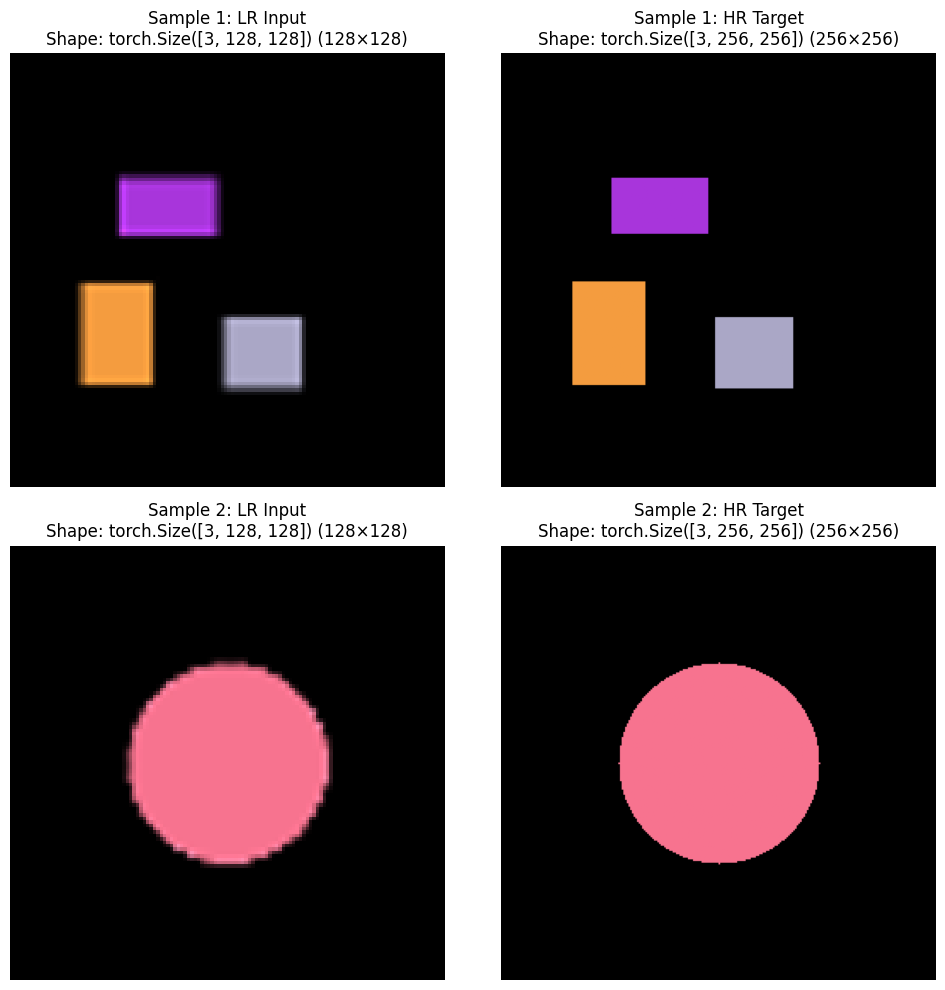

✓ Dataset verification complete
  LR images: Resized to 128×128 (network input)
  HR images: Resized to 256×256 (target output)
  Model will upsample 128×128 → 256×256 using PixelShuffle
  Total samples: 1000


In [17]:
import matplotlib.pyplot as plt
import random

# Select 2 random samples
sample_indices = random.sample(range(len(full_dataset)), 2)

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

for i, idx in enumerate(sample_indices):
    lr_img, hr_img = full_dataset[idx]
    
    # Convert to numpy for display
    lr_np = lr_img.numpy().transpose(1, 2, 0)
    hr_np = hr_img.numpy().transpose(1, 2, 0)
    
    # Display LR
    axes[i, 0].imshow(lr_np)
    axes[i, 0].set_title(f'Sample {i+1}: LR Input\nShape: {lr_img.shape} (128×128)')
    axes[i, 0].axis('off')
    
    # Display HR
    axes[i, 1].imshow(hr_np)
    axes[i, 1].set_title(f'Sample {i+1}: HR Target\nShape: {hr_img.shape} (256×256)')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

print(f"✓ Dataset verification complete")
print(f"  LR images: Resized to 128×128 (network input)")
print(f"  HR images: Resized to 256×256 (target output)")
print(f"  Model will upsample 128×128 → 256×256 using PixelShuffle")
print(f"  Total samples: {len(full_dataset)}")

## 7. Model Initialization

### Components:
- **Model**: ConvKAN_SR with reduced filters for memory efficiency
- **Loss Function**: L1 Loss (MAE) - preserves sharp edges better than MSE
- **Optimizer**: AdamW with weight decay for regularization
- **Mixed Precision**: GradScaler for faster training with float16

**Parameter Count:**
ConvKAN has more parameters than standard Conv2d due to learnable spline coefficients. The model will display total trainable parameters.

In [18]:
# Initialize model with PixelShuffle architecture
model = ConvKAN_SR(
    in_channels=3, 
    out_channels=3, 
    base_filters=BASE_FILTERS, 
    n_res_blocks=N_RES_BLOCKS,
    upscale_factor=UPSCALE_FACTOR
).to(device)

# Loss and optimizer
criterion = nn.L1Loss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

# Mixed precision training
scaler = torch.amp.GradScaler('cuda')

# Enable memory optimizations
if device.type == 'cuda':
    # Enable TF32 for faster training on Ampere+ GPUs
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    
    # Enable cudnn benchmarking for faster convolutions
    torch.backends.cudnn.benchmark = True
    
    # Set memory allocator settings
    os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:128,expandable_segments:True'
    
    print("✓ GPU optimizations enabled:")
    print("  - TF32 precision")
    print("  - CuDNN benchmarking")
    print("  - Memory allocator optimized")

# Print model info
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nModel Statistics:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Model size: ~{total_params * 4 / 1024**2:.2f} MB (float32)")
print(f"  Model size: ~{total_params * 2 / 1024**2:.2f} MB (float16/mixed precision)")
print(f"\n✓ Ready to train with PixelShuffle architecture (128×128 → 256×256)")


Initializing ConvKAN_SR with PixelShuffle
  Input channels:    3
  Output channels:   3
  Base filters:      16
  Residual blocks:   2
  Upscale factor:    2×
  Processing size:   128×128
  Output size:       256×256

Total parameters: 189,235 (0.19M)
✓ GPU optimizations enabled:
  - TF32 precision
  - CuDNN benchmarking
  - Memory allocator optimized

Model Statistics:
  Total parameters: 189,235
  Trainable parameters: 189,235
  Model size: ~0.72 MB (float32)
  Model size: ~0.36 MB (float16/mixed precision)

✓ Ready to train with PixelShuffle architecture (128×128 → 256×256)


## 8. Training and Validation Functions

### train_epoch()
Trains the model for one complete epoch with mixed precision:
1. Set model to training mode
2. For each batch:
   - Forward pass with autocast (float16)
   - Calculate L1 loss
   - Backward pass with gradient scaling
   - Update weights
3. Return average loss

### validate()
Evaluates model on validation set:
1. Set model to eval mode
2. Disable gradients for faster inference
3. Calculate average loss
4. Return validation loss

**Memory Management:**
- Clears GPU cache between epochs
- Uses `zero_grad(set_to_none=True)` for efficient memory cleanup

In [19]:
def train_epoch(model, train_loader, criterion, optimizer, scaler, device):
    """Train for one epoch with mixed precision"""
    model.train()
    running_loss = 0.0
    
    pbar = tqdm(train_loader, desc='Training')
    for lr_imgs, hr_imgs in pbar:
        lr_imgs = lr_imgs.to(device, non_blocking=True)
        hr_imgs = hr_imgs.to(device, non_blocking=True)
        
        optimizer.zero_grad(set_to_none=True)
        
        # Mixed precision forward pass
        with torch.amp.autocast('cuda'):
            outputs = model(lr_imgs)
            loss = criterion(outputs, hr_imgs)
        
        # Scaled backward pass
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.6f}'})
    
    return running_loss / len(train_loader)


def validate(model, val_loader, criterion, device):
    """Validate model performance"""
    model.eval()
    running_loss = 0.0
    
    with torch.no_grad():
        for lr_imgs, hr_imgs in val_loader:
            lr_imgs = lr_imgs.to(device, non_blocking=True)
            hr_imgs = hr_imgs.to(device, non_blocking=True)
            
            with torch.amp.autocast('cuda'):
                outputs = model(lr_imgs)
                loss = criterion(outputs, hr_imgs)
            
            running_loss += loss.item()
    
    return running_loss / len(val_loader)

## 9. Training Loop

Main training loop that runs for all epochs.

### Process:
1. **Clear GPU cache** at start of each epoch
2. **Train** on training set
3. **Validate** on validation set
4. **Record** losses to history
5. **Save checkpoints**:
   - Best model (lowest validation loss)
   - Periodic checkpoints every 10 epochs

### What to Monitor:
- Training loss should decrease steadily
- Validation loss should track training loss
- Large gap indicates overfitting
- GPU memory usage (printed after each epoch)

**Training Time:**
- ConvKAN is slower than standard CNN due to spline computations
- Expect ~30-60 seconds per epoch (GPU-dependent)
- Total training: ~30-50 minutes for 50 epochs

In [20]:
# Training history
history = {
    'train_loss': [],
    'val_loss': []
}

best_val_loss = float('inf')

print("\n" + "="*60)
print("Starting ConvKAN Training")
print("="*60 + "\n")

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 60)
    
    # Clear GPU cache
    torch.cuda.empty_cache()
    
    # Train
    train_loss = train_epoch(model, train_loader, criterion, optimizer, scaler, device)
    
    # Validate
    val_loss = validate(model, val_loader, criterion, device)
    
    # Record
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    
    # Print results
    print(f"\nTrain Loss: {train_loss:.6f}")
    print(f"Val Loss:   {val_loss:.6f}")
    
    # GPU memory stats
    if torch.cuda.is_available():
        print(f"GPU Memory: {torch.cuda.max_memory_allocated() / 1024**3:.2f} GB peak")
        torch.cuda.reset_peak_memory_stats()
    
    # Save best model (ConvKAN-specific filename)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'train_loss': train_loss,
        }, CHECKPOINT_DIR / 'convkan_best.pth')
        print(f"✓ Saved best model (val_loss: {val_loss:.6f})")
    
    # Periodic checkpoint (ConvKAN-specific filename)
    if (epoch + 1) % 10 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
        }, CHECKPOINT_DIR / f'convkan_epoch_{epoch+1}.pth')
        print(f"✓ Saved checkpoint: convkan_epoch_{epoch+1}")

print("\n" + "="*60)
print("Training Complete!")
print(f"Best validation loss: {best_val_loss:.6f}")
print("="*60)


Starting ConvKAN Training


Epoch 1/50
------------------------------------------------------------


Training: 100%|████████████████| 900/900 [02:38<00:00,  5.66it/s, loss=0.018528]



Train Loss: 0.033394
Val Loss:   0.022251
GPU Memory: 3.23 GB peak
✓ Saved best model (val_loss: 0.022251)

Epoch 2/50
------------------------------------------------------------


Training: 100%|████████████████| 900/900 [02:38<00:00,  5.68it/s, loss=0.018220]



Train Loss: 0.017585
Val Loss:   0.016854
GPU Memory: 3.23 GB peak
✓ Saved best model (val_loss: 0.016854)

Epoch 3/50
------------------------------------------------------------


Training: 100%|████████████████| 900/900 [02:38<00:00,  5.68it/s, loss=0.012876]



Train Loss: 0.014855
Val Loss:   0.013886
GPU Memory: 3.23 GB peak
✓ Saved best model (val_loss: 0.013886)

Epoch 4/50
------------------------------------------------------------


Training: 100%|████████████████| 900/900 [02:38<00:00,  5.68it/s, loss=0.009772]



Train Loss: 0.013085
Val Loss:   0.012147
GPU Memory: 3.23 GB peak
✓ Saved best model (val_loss: 0.012147)

Epoch 5/50
------------------------------------------------------------


Training: 100%|████████████████| 900/900 [02:38<00:00,  5.68it/s, loss=0.012755]



Train Loss: 0.012267
Val Loss:   0.011316
GPU Memory: 3.23 GB peak
✓ Saved best model (val_loss: 0.011316)

Epoch 6/50
------------------------------------------------------------


Training: 100%|████████████████| 900/900 [02:38<00:00,  5.68it/s, loss=0.007269]



Train Loss: 0.011120
Val Loss:   0.010490
GPU Memory: 3.23 GB peak
✓ Saved best model (val_loss: 0.010490)

Epoch 7/50
------------------------------------------------------------


Training: 100%|████████████████| 900/900 [02:38<00:00,  5.69it/s, loss=0.008393]



Train Loss: 0.010367
Val Loss:   0.010458
GPU Memory: 3.23 GB peak
✓ Saved best model (val_loss: 0.010458)

Epoch 8/50
------------------------------------------------------------


Training: 100%|████████████████| 900/900 [02:38<00:00,  5.69it/s, loss=0.010001]



Train Loss: 0.009864
Val Loss:   0.009455
GPU Memory: 3.23 GB peak
✓ Saved best model (val_loss: 0.009455)

Epoch 9/50
------------------------------------------------------------


Training: 100%|████████████████| 900/900 [02:38<00:00,  5.69it/s, loss=0.010869]



Train Loss: 0.009546
Val Loss:   0.008959
GPU Memory: 3.23 GB peak
✓ Saved best model (val_loss: 0.008959)

Epoch 10/50
------------------------------------------------------------


Training: 100%|████████████████| 900/900 [02:38<00:00,  5.69it/s, loss=0.011126]



Train Loss: 0.009222
Val Loss:   0.009431
GPU Memory: 3.23 GB peak
✓ Saved checkpoint: convkan_epoch_10

Epoch 11/50
------------------------------------------------------------


Training: 100%|████████████████| 900/900 [02:38<00:00,  5.69it/s, loss=0.008912]



Train Loss: 0.008515
Val Loss:   0.009219
GPU Memory: 3.23 GB peak

Epoch 12/50
------------------------------------------------------------


Training: 100%|████████████████| 900/900 [02:38<00:00,  5.69it/s, loss=0.006552]



Train Loss: 0.008548
Val Loss:   0.008618
GPU Memory: 3.23 GB peak
✓ Saved best model (val_loss: 0.008618)

Epoch 13/50
------------------------------------------------------------


Training: 100%|████████████████| 900/900 [02:38<00:00,  5.68it/s, loss=0.008852]



Train Loss: 0.007953
Val Loss:   0.006875
GPU Memory: 3.23 GB peak
✓ Saved best model (val_loss: 0.006875)

Epoch 14/50
------------------------------------------------------------


Training: 100%|████████████████| 900/900 [02:38<00:00,  5.69it/s, loss=0.005340]



Train Loss: 0.007851
Val Loss:   0.007583
GPU Memory: 3.23 GB peak

Epoch 15/50
------------------------------------------------------------


Training: 100%|████████████████| 900/900 [02:38<00:00,  5.68it/s, loss=0.005984]



Train Loss: 0.007685
Val Loss:   0.007148
GPU Memory: 3.23 GB peak

Epoch 16/50
------------------------------------------------------------


Training: 100%|████████████████| 900/900 [02:38<00:00,  5.68it/s, loss=0.006837]



Train Loss: 0.007357
Val Loss:   0.006219
GPU Memory: 3.23 GB peak
✓ Saved best model (val_loss: 0.006219)

Epoch 17/50
------------------------------------------------------------


Training: 100%|████████████████| 900/900 [02:38<00:00,  5.69it/s, loss=0.016255]



Train Loss: 0.007131
Val Loss:   0.007252
GPU Memory: 3.23 GB peak

Epoch 18/50
------------------------------------------------------------


Training: 100%|████████████████| 900/900 [02:38<00:00,  5.68it/s, loss=0.005223]



Train Loss: 0.007129
Val Loss:   0.005929
GPU Memory: 3.23 GB peak
✓ Saved best model (val_loss: 0.005929)

Epoch 19/50
------------------------------------------------------------


Training: 100%|████████████████| 900/900 [02:38<00:00,  5.68it/s, loss=0.006882]



Train Loss: 0.006903
Val Loss:   0.006887
GPU Memory: 3.23 GB peak

Epoch 20/50
------------------------------------------------------------


Training: 100%|████████████████| 900/900 [02:38<00:00,  5.69it/s, loss=0.007645]



Train Loss: 0.006749
Val Loss:   0.006093
GPU Memory: 3.23 GB peak
✓ Saved checkpoint: convkan_epoch_20

Epoch 21/50
------------------------------------------------------------


Training: 100%|████████████████| 900/900 [02:38<00:00,  5.69it/s, loss=0.004447]



Train Loss: 0.006654
Val Loss:   0.006611
GPU Memory: 3.23 GB peak

Epoch 22/50
------------------------------------------------------------


Training: 100%|████████████████| 900/900 [02:38<00:00,  5.69it/s, loss=0.006064]



Train Loss: 0.006421
Val Loss:   0.008339
GPU Memory: 3.23 GB peak

Epoch 23/50
------------------------------------------------------------


Training: 100%|████████████████| 900/900 [02:38<00:00,  5.69it/s, loss=0.006551]



Train Loss: 0.006421
Val Loss:   0.006478
GPU Memory: 3.23 GB peak

Epoch 24/50
------------------------------------------------------------


Training: 100%|████████████████| 900/900 [02:38<00:00,  5.69it/s, loss=0.007682]



Train Loss: 0.006172
Val Loss:   0.006878
GPU Memory: 3.23 GB peak

Epoch 25/50
------------------------------------------------------------


Training: 100%|████████████████| 900/900 [02:38<00:00,  5.69it/s, loss=0.004755]



Train Loss: 0.006276
Val Loss:   0.005703
GPU Memory: 3.23 GB peak
✓ Saved best model (val_loss: 0.005703)

Epoch 26/50
------------------------------------------------------------


Training: 100%|████████████████| 900/900 [02:38<00:00,  5.68it/s, loss=0.005487]



Train Loss: 0.005932
Val Loss:   0.005833
GPU Memory: 3.23 GB peak

Epoch 27/50
------------------------------------------------------------


Training: 100%|████████████████| 900/900 [02:38<00:00,  5.69it/s, loss=0.004937]



Train Loss: 0.006030
Val Loss:   0.006268
GPU Memory: 3.23 GB peak

Epoch 28/50
------------------------------------------------------------


Training: 100%|████████████████| 900/900 [02:38<00:00,  5.68it/s, loss=0.006858]



Train Loss: 0.006002
Val Loss:   0.005982
GPU Memory: 3.23 GB peak

Epoch 29/50
------------------------------------------------------------


Training: 100%|████████████████| 900/900 [02:38<00:00,  5.68it/s, loss=0.006823]



Train Loss: 0.005757
Val Loss:   0.006119
GPU Memory: 3.23 GB peak

Epoch 30/50
------------------------------------------------------------


Training: 100%|████████████████| 900/900 [02:38<00:00,  5.68it/s, loss=0.007122]



Train Loss: 0.005848
Val Loss:   0.005279
GPU Memory: 3.23 GB peak
✓ Saved best model (val_loss: 0.005279)
✓ Saved checkpoint: convkan_epoch_30

Epoch 31/50
------------------------------------------------------------


Training: 100%|████████████████| 900/900 [02:38<00:00,  5.69it/s, loss=0.006999]



Train Loss: 0.005492
Val Loss:   0.004646
GPU Memory: 3.23 GB peak
✓ Saved best model (val_loss: 0.004646)

Epoch 32/50
------------------------------------------------------------


Training: 100%|████████████████| 900/900 [02:38<00:00,  5.69it/s, loss=0.005745]



Train Loss: 0.005707
Val Loss:   0.005563
GPU Memory: 3.23 GB peak

Epoch 33/50
------------------------------------------------------------


Training: 100%|████████████████| 900/900 [02:38<00:00,  5.68it/s, loss=0.004981]



Train Loss: 0.005476
Val Loss:   0.006097
GPU Memory: 3.23 GB peak

Epoch 34/50
------------------------------------------------------------


Training: 100%|████████████████| 900/900 [02:38<00:00,  5.68it/s, loss=0.005739]



Train Loss: 0.005562
Val Loss:   0.005858
GPU Memory: 3.23 GB peak

Epoch 35/50
------------------------------------------------------------


Training: 100%|████████████████| 900/900 [02:38<00:00,  5.68it/s, loss=0.005408]



Train Loss: 0.005635
Val Loss:   0.006277
GPU Memory: 3.23 GB peak

Epoch 36/50
------------------------------------------------------------


Training: 100%|████████████████| 900/900 [02:38<00:00,  5.68it/s, loss=0.006355]



Train Loss: 0.005362
Val Loss:   0.005071
GPU Memory: 3.23 GB peak

Epoch 37/50
------------------------------------------------------------


Training: 100%|████████████████| 900/900 [02:38<00:00,  5.69it/s, loss=0.006387]



Train Loss: 0.005186
Val Loss:   0.005679
GPU Memory: 3.23 GB peak

Epoch 38/50
------------------------------------------------------------


Training: 100%|████████████████| 900/900 [02:38<00:00,  5.69it/s, loss=0.003015]



Train Loss: 0.005271
Val Loss:   0.004661
GPU Memory: 3.23 GB peak

Epoch 39/50
------------------------------------------------------------


Training: 100%|████████████████| 900/900 [02:39<00:00,  5.66it/s, loss=0.006388]



Train Loss: 0.005325
Val Loss:   0.005810
GPU Memory: 3.23 GB peak

Epoch 40/50
------------------------------------------------------------


Training: 100%|████████████████| 900/900 [02:38<00:00,  5.68it/s, loss=0.006679]



Train Loss: 0.005071
Val Loss:   0.005854
GPU Memory: 3.23 GB peak
✓ Saved checkpoint: convkan_epoch_40

Epoch 41/50
------------------------------------------------------------


Training: 100%|████████████████| 900/900 [02:38<00:00,  5.69it/s, loss=0.003726]



Train Loss: 0.005203
Val Loss:   0.005954
GPU Memory: 3.23 GB peak

Epoch 42/50
------------------------------------------------------------


Training: 100%|████████████████| 900/900 [02:38<00:00,  5.68it/s, loss=0.006541]



Train Loss: 0.005098
Val Loss:   0.005543
GPU Memory: 3.23 GB peak

Epoch 43/50
------------------------------------------------------------


Training: 100%|████████████████| 900/900 [02:38<00:00,  5.69it/s, loss=0.006617]



Train Loss: 0.005065
Val Loss:   0.005291
GPU Memory: 3.23 GB peak

Epoch 44/50
------------------------------------------------------------


Training: 100%|████████████████| 900/900 [02:38<00:00,  5.69it/s, loss=0.005304]



Train Loss: 0.005031
Val Loss:   0.004638
GPU Memory: 3.23 GB peak
✓ Saved best model (val_loss: 0.004638)

Epoch 45/50
------------------------------------------------------------


Training: 100%|████████████████| 900/900 [02:38<00:00,  5.69it/s, loss=0.003978]



Train Loss: 0.005014
Val Loss:   0.004653
GPU Memory: 3.23 GB peak

Epoch 46/50
------------------------------------------------------------


Training: 100%|████████████████| 900/900 [02:38<00:00,  5.69it/s, loss=0.004789]



Train Loss: 0.004783
Val Loss:   0.005310
GPU Memory: 3.23 GB peak

Epoch 47/50
------------------------------------------------------------


Training: 100%|████████████████| 900/900 [02:38<00:00,  5.69it/s, loss=0.004733]



Train Loss: 0.004880
Val Loss:   0.004524
GPU Memory: 3.23 GB peak
✓ Saved best model (val_loss: 0.004524)

Epoch 48/50
------------------------------------------------------------


Training: 100%|████████████████| 900/900 [02:38<00:00,  5.69it/s, loss=0.001871]



Train Loss: 0.004818
Val Loss:   0.003870
GPU Memory: 3.23 GB peak
✓ Saved best model (val_loss: 0.003870)

Epoch 49/50
------------------------------------------------------------


Training: 100%|████████████████| 900/900 [02:38<00:00,  5.69it/s, loss=0.002275]



Train Loss: 0.004741
Val Loss:   0.004378
GPU Memory: 3.23 GB peak

Epoch 50/50
------------------------------------------------------------


Training: 100%|████████████████| 900/900 [02:38<00:00,  5.68it/s, loss=0.005541]



Train Loss: 0.004721
Val Loss:   0.005635
GPU Memory: 3.23 GB peak
✓ Saved checkpoint: convkan_epoch_50

Training Complete!
Best validation loss: 0.003870


## 10. Training Curve Visualization

Plot training and validation loss curves over all epochs.

**Analysis:**
- **Decreasing trend**: Both curves should trend downward
- **Convergence**: Curves should flatten near the end
- **Overfitting**: Val loss increasing while train loss decreases
- **Underfitting**: Both losses remain high

The plot is saved for documentation and model comparison.

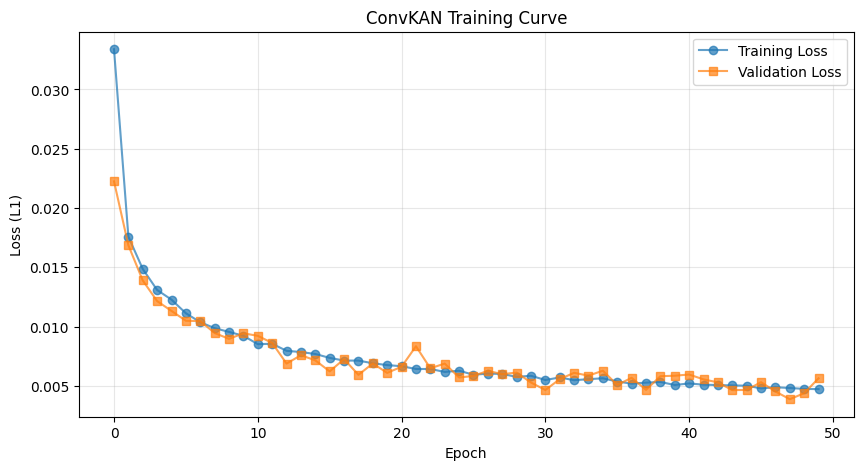

Training curve saved: checkpoints_convkan/convkan_training_curve.png


In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Training Loss', marker='o', alpha=0.7)
plt.plot(history['val_loss'], label='Validation Loss', marker='s', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('Loss (L1)')
plt.title('ConvKAN Training Curve')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(CHECKPOINT_DIR / 'convkan_training_curve.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Training curve saved: {CHECKPOINT_DIR / 'convkan_training_curve.png'}")

## 11. Training Summary

Generate and save a comprehensive training summary including:
- Model architecture details
- Hyperparameters
- Final performance metrics
- File paths to saved models

This summary is saved as a text file for experiment tracking and comparison with other models (e.g., U-Net).

In [22]:
# Load best model for final summary
checkpoint = torch.load(CHECKPOINT_DIR / 'convkan_best.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

summary = f"""
ConvKAN Super-Resolution Training Summary
{'='*60}

Model Architecture:
  Type: ConvKAN with PixelShuffle Upsampling
  Base Filters: {BASE_FILTERS}
  Residual Blocks: {N_RES_BLOCKS}
  Upscale Factor: {UPSCALE_FACTOR}×
  Total Parameters: {total_params:,}

Training Configuration:
  Epochs: {NUM_EPOCHS}
  Batch Size: {BATCH_SIZE}
  Learning Rate: {LEARNING_RATE}
  Loss Function: L1 Loss (MAE)
  Optimizer: AdamW with weight decay
  Mixed Precision: Enabled

Dataset:
  Total Images: {len(full_dataset)}
  Training: {train_size} images
  Validation: {val_size} images
  Input Size: {LR_SIZE}×{LR_SIZE} (network processes here)
  Output Size: {HR_SIZE}×{HR_SIZE} (via PixelShuffle)

Final Results:
  Best Validation Loss: {best_val_loss:.6f}
  Best Epoch: {checkpoint['epoch'] + 1}
  Final Train Loss: {checkpoint['train_loss']:.6f}

Saved Files:
  Best Model: {CHECKPOINT_DIR / 'convkan_best.pth'}
  Training Curve: {CHECKPOINT_DIR / 'convkan_training_curve.png'}
  
Notes:
  - Uses PixelShuffle architecture for memory efficiency
  - Processes at 128×128, upsamples to 256×256
  - Separate from U-Net model (different checkpoint directory)
  - Ready for evaluation with evaluate_convkan.ipynb
"""

print(summary)

with open(CHECKPOINT_DIR / 'convkan_training_summary.txt', 'w', encoding='utf-8') as f:
    f.write(summary)

print(f"\nSummary saved: {CHECKPOINT_DIR / 'convkan_training_summary.txt'}")


ConvKAN Super-Resolution Training Summary

Model Architecture:
  Type: ConvKAN with PixelShuffle Upsampling
  Base Filters: 16
  Residual Blocks: 2
  Upscale Factor: 2×
  Total Parameters: 189,235

Training Configuration:
  Epochs: 50
  Batch Size: 1
  Learning Rate: 0.0001
  Loss Function: L1 Loss (MAE)
  Optimizer: AdamW with weight decay
  Mixed Precision: Enabled

Dataset:
  Total Images: 1000
  Training: 900 images
  Validation: 100 images
  Input Size: 128×128 (network processes here)
  Output Size: 256×256 (via PixelShuffle)

Final Results:
  Best Validation Loss: 0.003870
  Best Epoch: 48
  Final Train Loss: 0.004818

Saved Files:
  Best Model: checkpoints_convkan/convkan_best.pth
  Training Curve: checkpoints_convkan/convkan_training_curve.png

Notes:
  - Uses PixelShuffle architecture for memory efficiency
  - Processes at 128×128, upsamples to 256×256
  - Separate from U-Net model (different checkpoint directory)
  - Ready for evaluation with evaluate_convkan.ipynb


Summar

## 12. Next Steps

Training is complete! To evaluate your model:

1. **Run the evaluation notebook**: `evaluate_convkan.ipynb`
   - Calculates PSNR and SSIM metrics
   - Generates visual comparisons (LR vs SR vs HR)
   - Side-by-side comparison with U-Net results

2. **Compare with U-Net**:
   - Check if ConvKAN achieves better PSNR/SSIM
   - Analyze visual quality differences
   - Consider training time vs performance trade-off

3. **Further Improvements** (if needed):
   - Increase `BASE_FILTERS` to 32 (if GPU memory allows)
   - Add more residual blocks (`N_RES_BLOCKS = 4`)
   - Train for more epochs (100+)
   - Try learning rate scheduling
   - Experiment with perceptual loss instead of L1

**Model Files:**
- Best model: `checkpoints_convkan/convkan_best.pth`
- Training curve: `checkpoints_convkan/convkan_training_curve.png`
- Summary: `checkpoints_convkan/convkan_training_summary.txt`

**Note:** ConvKAN model files are separate from U-Net (`checkpoints/best_model.pth`)